In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

In [5]:
data_dir = "/Volumes/External_HD/Data/Tensor_Flow_Data/TF_2_Notebooks_and_Data/cell_images"

In [6]:
os.listdir(data_dir)

['test', 'train']

### Allows you to read in images directly

In [7]:
from matplotlib.image import imread

In [8]:
test_path = data_dir+"/test/"
train_path = data_dir+"/train/"

In [9]:
train_path

'/Volumes/External_HD/Data/Tensor_Flow_Data/TF_2_Notebooks_and_Data/cell_images/train/'

In [10]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [11]:
os.listdir(train_path)

['parasitized', 'uninfected']

### Lets take a look at one of the images 

In [12]:
os.listdir(train_path+"parasitized")[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [13]:
single_Cell = train_path+"parasitized"+"/C100P61ThinF_IMG_20150918_144104_cell_162.png"

In [14]:
imread(single_Cell).shape

(148, 142, 3)

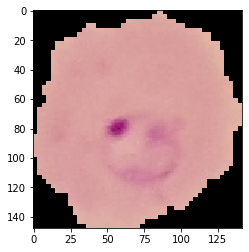

In [15]:
plt.imshow(imread(single_Cell))

### uninfected Call

In [16]:
os.listdir(train_path+"/uninfected")[0]

'C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [17]:
uninfected_cell = train_path+"uninfected"+"/C100P61ThinF_IMG_20150918_144104_cell_128.png"

In [18]:
uninfected_cell

'/Volumes/External_HD/Data/Tensor_Flow_Data/TF_2_Notebooks_and_Data/cell_images/train/uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'

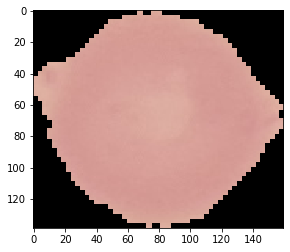

In [19]:
plt.imshow(imread(uninfected_cell))

## Check how many images we have

In [20]:
len(os.listdir(train_path+"parasitized"))

12480

In [21]:
len(os.listdir(test_path+"uninfected"))

1300

### Shaping the images 
- These have different demensions 
- How will we handle this

In [25]:
imread(train_path+"uninfected"+"/C100P61ThinF_IMG_20150918_144104_cell_128.png").shape

(139, 160, 3)

In [26]:
dem1 = []
dem2 = []

for image_file in os.listdir(test_path+"uninfected"):
    img = imread(test_path+"uninfected/"+image_file)
    d1,d2,color = img.shape
    dem1.append(d1)
    dem2.append(d2)

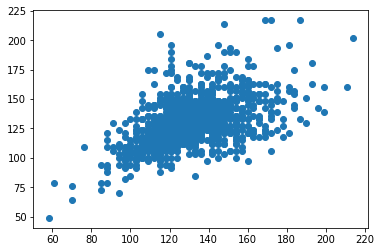

In [27]:
plt.scatter(dem1, dem2)

## WE see images of various sizes so what we need to do is resize all iamges to be the same size
- SHould be the average of both images
- Images are averaging around 130/131 pix

In [28]:
np.mean(dem1)

130.92538461538462

In [29]:
np.mean(dem2)

130.75

## Image for networks
- We will feed the below image size into the network

In [58]:
image_shape = (130,130,3)

### image data generator
- fed in the directory into the generator and minipulating images 
- Because our data demensions will be very large - see below we will ned to feed in batches in to th model
- model need to overcome and be robost enough to deal with images that are very different than what it seen before
- Minipultae anbd transforming, sizing, rotating, scaling


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Lets see what the genrator does
 - We have not to many images so what we wnat to be able to do is expand the number of images with out having to ather cells from people. 
 - So rotate the images randomly
 - width shift range - eg 0.1 - randomally shift the width o the image between 0 and 10% 
 - because ou images are oval we can up these values to a bit larger
- if we are dealing for faces yo dont want to rotate too much
- rescale the image  if not caled we can set to 1/255
- shear range = 0.1 -> curt away part of the image
- zoom range = 0.1 - zooma in and out 
- fill mode => if the image is sretched in the shift will fill with the nearest pixel value 

In [80]:
image_gen = ImageDataGenerator(rotation_range=45, 
                               width_shift_range= 0.1, height_shift_range=0.1, 
                               zoom_range=0.1, horizontal_flip=True, fill_mode="nearest")

## WE will tet the image gen on the sample call and see how it performs 

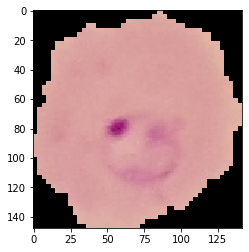

In [81]:
parasit_image = imread(single_Cell)
plt.imshow(parasit_image)

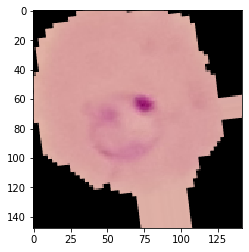

In [82]:
plt.imshow(image_gen.random_transform(parasit_image))

In [83]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [84]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


### creating Model

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Dense, Conv2D, Dropout, Flatten

In [90]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = image_shape,activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = image_shape,activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = image_shape,activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 150, activation = "relu"))
model.add(Dropout(rate =0.50))
model.add(Dense(units = 1,activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)            

In [92]:
from tensorflow.keras.callbacks import EarlyStopping

In [93]:
stop = EarlyStopping(monitor="val_loss", mode = "min", patience=2)

In [94]:
batch_size = 16

In [95]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2],
                                               color_mode="rgb", batch_size=batch_size, class_mode="binary")

Found 24958 images belonging to 2 classes.


In [96]:
test_image_gen  = image_gen.flow_from_directory(test_path, target_size=image_shape[:2],
                                               color_mode="rgb", batch_size=batch_size,
                                                class_mode="binary", shuffle=False )

Found 2600 images belonging to 2 classes.


In [98]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
results = model.fit_generator(train_image_gen,epochs=10, validation_data=test_image_gen, callbacks=[stop])

Epoch 1/10
